In [112]:
%matplotlib inline

import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections

In [113]:
# From previous exercise
def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def psi(y):
    return 1 - 2 * sigmoid(y)

def update_natural(W, x):
    n = x.shape[0]
    phee = psi(W.dot(x)).reshape(n, 1)
    delta_W = np.dot(phee.dot(np.dot(W, x).reshape(1, n)), W)
    delta_W = delta_W + W  # multiplied out delta function
    for i in range(n):  # Bell-Sejnowski solution
        delta_W[i, i] = 0
    return delta_W

def plot(ax, data, **kwargs):
    ax.plot(data, **kwargs)
    ax.set_title(kwargs['label'])
    scipy.io.wavfile.write(kwargs['label'] + '.wav', 8192, data),

def online_ica(X, X0, lambda_= 0.99, epsilon = 0.001, eta = 0.15):
    n = X.shape[0]  # Number of sources
    W = np.linalg.inv(np.random.RandomState(seed+1).rand(n, n))
    for i in range(n):  # Bell-Sejnowski solution
        W[i, i] = 1
    time = 0
    while eta > epsilon:
        example = X.T[time % X.shape[1]]
        eta = eta * lambda_
        W += eta * update_natural(W, example)
        time += 1
    print("Calculated unmixing matrix in {} steps".format(time))
    return W.dot(X0)

seed = 13  # seed for random states to get always the same result
sound1 = np.loadtxt('sounds/sound1.dat')
sound2 = np.loadtxt('sounds/sound2.dat')

Calculated unmixing matrix in 499 steps


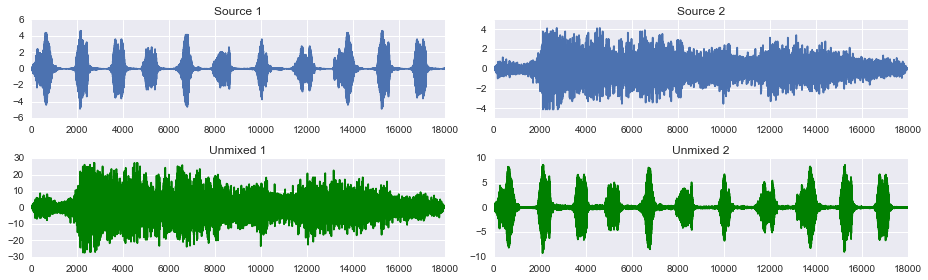

In [114]:
# 7.1. (a) Online ICA with natural gradient decaying slowly to 0
sounds = np.concatenate([[sound1, sound2]], axis=1)
A = np.linalg.inv(np.random.RandomState(seed+4).rand(2,2))
X0 = A.dot(sounds)
X = X0[:,np.random.RandomState(seed+1).permutation(X0.shape[1])]
X -= X.mean(axis=1).reshape((2, 1))
unmixed_nat = online_ica(X, X0)

fig, ax = plt.subplots(2, 2, figsize=(13, 4))
plot(ax[0, 0], sound1, label='Source 1')
plot(ax[0, 1], sound2, label='Source 2')
plot(ax[1, 0], unmixed_nat[0,:], label='Unmixed 1', color='green')
plot(ax[1, 1], unmixed_nat[1,:], label='Unmixed 2', color='green')
fig.tight_layout()

In [115]:
def laplace_rand(*shape):
    return np.random.RandomState(seed).laplace(size=np.array(shape).prod()).reshape(*shape)

def normally_rand(*shape):
    result = np.random.RandomState(seed).rand(*shape) * sound1.max()
    result[::2] *= -1
    return result

def generate_sample(sound, rand_gen=normally_rand):
    new_sound = rand_gen(*sound.shape)
    std = sound.std()
    std_rounded = int(std * 1000) / 1000
    std_n = 0
    steps = 0
    while int(std_n * 1000) / 1000 != std_rounded:
        pos = np.random.RandomState(steps).randint(new_sound.shape[0])
        if std_n > std:
            new_sound[pos] = new_sound.mean()
        else:
            new_sound[pos] += std
        std_n = new_sound.std()
        steps += 1
    print("Generating third sample took {} steps".format(steps))
    return new_sound

Generating third sample took 34926 steps
Calculated unmixing matrix in 8696 steps


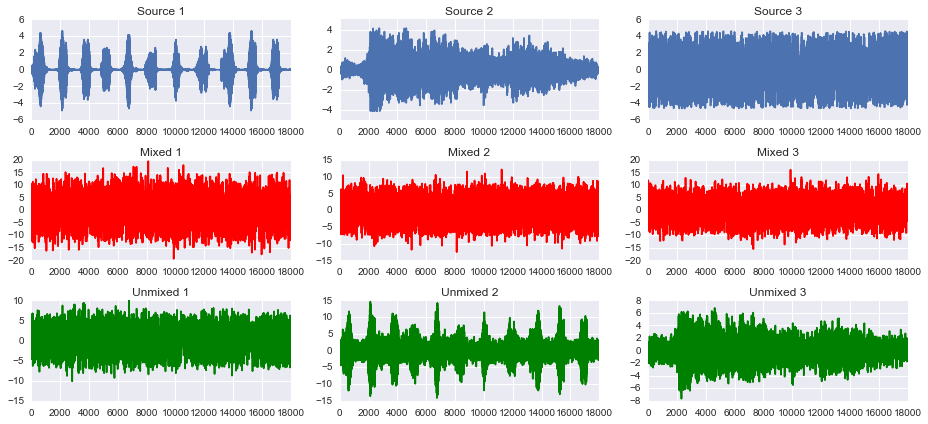

In [126]:
# 7.1 (b)
sound3 = generate_sample(sound1)
sounds = np.concatenate([[sound1, sound2, sound3]], axis=1)
A = np.linalg.inv(np.random.RandomState(seed).rand(3,3))
X0 = A.dot(sounds)
X = X0[:,np.random.RandomState(seed+1).permutation(X0.shape[1])]
X -= X.mean(axis=1).reshape((3, 1))
unmixed3_nat = online_ica(X, X0, lambda_ = 0.999, eta = 0.06, epsilon=0.00001)
# The result might be too loud
for result in unmixed3_nat:
    if result.max() > 15:
        result /= result.max() / 10

fig, ax = plt.subplots(3, 3, figsize=(13, 6))
plot(ax[0, 0], sound1, label='Source 1')
plot(ax[0, 1], sound2, label='Source 2')
plot(ax[0, 2], sound3, label='Source 3')
plot(ax[1, 0], X[0, :], label='Mixed 1', color='red')
plot(ax[1, 1], X[1, :], label='Mixed 2', color='red')
plot(ax[1, 2], X[2, :], label='Mixed 3', color='red')
plot(ax[2, 0], unmixed3_nat[0,:], label='Unmixed 1', color='green')
plot(ax[2, 1], unmixed3_nat[1,:], label='Unmixed 2', color='green')
plot(ax[2, 2], unmixed3_nat[2,:], label='Unmixed 3', color='green')
fig.tight_layout()

Generating third sample took 12538 steps
Calculated unmixing matrix in 85168 steps


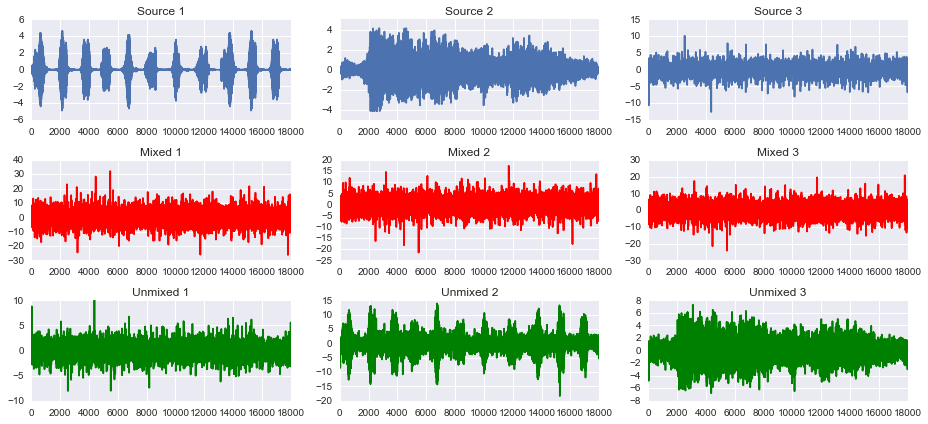

In [117]:
# 7.1 (c)
sound3 = generate_sample(sound1, rand_gen=laplace_rand)
sounds = np.concatenate([[sound1, sound2, sound3]], axis=1)
A = np.linalg.inv(np.random.RandomState(seed).rand(3,3))
X0 = A.dot(sounds)
X = X0[:,np.random.RandomState(seed+1).permutation(X0.shape[1])]
X -= X.mean(axis=1).reshape((3, 1))
unmixed3_nat = online_ica(X, X0, lambda_ = 0.9999, eta = 0.05, epsilon=0.00001)
# The result might be too loud
for result in unmixed3_nat:
    if result.max() > 15:
        result /= result.max() / 10

fig, ax = plt.subplots(3, 3, figsize=(13, 6))
plot(ax[0, 0], sound1, label='Source 1')
plot(ax[0, 1], sound2, label='Source 2')
plot(ax[0, 2], sound3, label='Source 3')
plot(ax[1, 0], X[0, :], label='Mixed 1', color='red')
plot(ax[1, 1], X[1, :], label='Mixed 2', color='red')
plot(ax[1, 2], X[2, :], label='Mixed 3', color='red')
plot(ax[2, 0], unmixed3_nat[0,:], label='Unmixed 1', color='green')
plot(ax[2, 1], unmixed3_nat[1,:], label='Unmixed 2', color='green')
plot(ax[2, 2], unmixed3_nat[2,:], label='Unmixed 3', color='green')
fig.tight_layout()

In [118]:
mat = scipy.io.loadmat('distrib.mat')
uniform = mat['uniform']
normal = mat['normal']
laplacian = mat['laplacian']

A = np.array([[4,3],[2,1]])

In [119]:
def plot_dataset(data, title='', xlabel='Source 1', ylabel='Source 2'):
    df = pd.DataFrame(data.T, columns=[xlabel, ylabel])
#     g = sns.jointplot(x=xlabel, y=ylabel, data=df)
#     sns.plt.suptitle(title, fontsize=20, y=1.08)

In [120]:
def procedure(s):
    #Plot the original sources
    plot_dataset(s, title='Original sources')
    
    #7.3a - Apply mixing matrix A and plot mixed data
    x = np.dot(A,s)
    plot_dataset(x, title='After mixing', xlabel='Mixed 1', ylabel='Mixed 2')
    
    #7.3b - Center to mean 0 and plot centered data
    x = x - np.mean(x,axis=1).reshape(2,1)
    plot_dataset(x, title='After centering', xlabel='Centered 1', ylabel='Centered 2')
    
    #7.3c - Decorrelate by PCA and project onto the principal components
    # (consult: 1. eig vs eigh 2. should we sort eigvals?)
    covmat = np.cov(x)
    eigvals, eigvecs = np.linalg.eig(covmat)

In [121]:
procedure(normal)

In [122]:
def kurtosis_of_dist(s):
    x = np.dot(A,s)
    x -= np.mean(x)

In [123]:

# sns.set(color_codes=True)


# mean, cov = [0, 1], [(1, .5), (.5, 1)]
# data = np.random.multivariate_normal(mean, cov, 200)
# df = pd.DataFrame(data, columns=["x", "y"])

# sns.jointplot(x="x", y="y", data=df);